Описание/Пошаговая инструкция выполнения домашнего задания:

- реализуйте алгоритм на основе политик А2С, DDPG;
- обучите агента в среде Car Racing;
- представьте исходный код, обученного агента и графики обучения агента.

PS: https://github.com/xtma/pytorch_car_caring/tree/master

In [1]:
import visdom

class DrawLine:

    def __init__(self, env, title, xlabel=None, ylabel=None):
        self.vis = visdom.Visdom()
        self.update_flag = False
        self.env = env
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.title = title

    def __call__(
            self,
            xdata,
            ydata,
    ):
        if not self.update_flag:
            self.win = self.vis.line(
                X=np.array([xdata]),
                Y=np.array([ydata]),
                opts=dict(
                    xlabel=self.xlabel,
                    ylabel=self.ylabel,
                    title=self.title,
                ),
                env=self.env,
            )
            self.update_flag = True
        else:
            self.vis.line(
                X=np.array([xdata]),
                Y=np.array([ydata]),
                win=self.win,
                env=self.env,
                update='append',
            )

In [2]:
import argparse
import numpy as np
import gymnasium as gym
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

parser = argparse.ArgumentParser(description='Train a PPO agent for the CarRacing-v2')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G', help='discount factor (default: 0.99)')
parser.add_argument('--action-repeat', type=int, default=8, metavar='N', help='repeat action in N frames (default: 8)')
parser.add_argument('--img-stack', type=int, default=4, metavar='N', help='stack N image in a state (default: 4)')
parser.add_argument('--seed', type=int, default=0, metavar='N', help='random seed (default: 0)')
parser.add_argument('--render', default=False, action='store_true', help='render the environment')
parser.add_argument('--vis', default=False, action='store_true', help='use visdom')
parser.add_argument(
    '--log-interval', type=int, default=10, metavar='N', help='interval between training status logs (default: 10)')
args, unknown = parser.parse_known_args()

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [4]:
torch.manual_seed(args.seed)
if use_cuda:
    torch.cuda.manual_seed(args.seed)

transition = np.dtype([('s', np.float64, (args.img_stack, 96, 96)), ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (args.img_stack, 96, 96))])

class Env:
    """
    Environment wrapper for CarRacing
    """

    def __init__(self, render_mode=None):
        self.env = gym.make('CarRacing-v2', render_mode)
        # self.env.seed(args.seed)
        self.reward_threshold = self.env.spec.reward_threshold

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb, info = self.env.reset()
        img_gray = self.rgb2gray(img_rgb)
        self.stack = [img_gray] * args.img_stack  # four frames for decision
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(args.action_repeat):
            img_rgb, reward, die, truncated, _ = self.env.step(action)
            # don't penalize "die state"
            if die: # or truncated:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = self.rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == args.img_stack
        return np.array(self.stack), total_reward, done, die

    def render(self, *arg):
        self.env.render(*arg)

    @staticmethod
    def rgb2gray(rgb, norm=True):
        # rgb image -> gray [0, 1]
        gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
        if norm:
            # normalize
            gray = gray / 128. - 1.
        return gray

    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

<img src="https://github.com/xtma/pytorch_car_caring/raw/master/img/network.png" width="400" />

In [5]:
class Net(nn.Module):
    """
    Actor-Critic Network for PPO
    """

    def __init__(self):
        super(Net, self).__init__()
        self.cnn_base = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(args.img_stack, 8, kernel_size=4, stride=2),
            nn.ReLU(),  # activation
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),  # activation
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),  # activation
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),  # activation
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1

        return (alpha, beta), v


In [6]:
class Agent:
    """
    Agent for training
    """
    max_grad_norm = 0.5
    clip_param = 0.1  # epsilon in clipped loss
    ppo_epoch = 10
    buffer_capacity, batch_size = 2000, 128

    def __init__(self):
        self.training_step = 0
        self.net = Net().double().to(device)
        self.buffer = np.empty(self.buffer_capacity, dtype=transition)
        self.counter = 0

        self.optimizer = optim.Adam(self.net.parameters(), lr=1e-3)

    def select_action(self, state):
        state = torch.from_numpy(state).double().to(device).unsqueeze(0)
        with torch.no_grad():
            alpha, beta = self.net(state)[0]
        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp

    def save_param(self):
        torch.save(self.net.state_dict(), 'target/ppo_net_params.pkl')

    def store(self, transition):
        self.buffer[self.counter] = transition
        self.counter += 1
        if self.counter == self.buffer_capacity:
            self.counter = 0
            return True
        else:
            return False

    def update(self):
        self.training_step += 1

        s = torch.tensor(self.buffer['s'], dtype=torch.double).to(device)
        a = torch.tensor(self.buffer['a'], dtype=torch.double).to(device)
        r = torch.tensor(self.buffer['r'], dtype=torch.double).to(device).view(-1, 1)
        s_ = torch.tensor(self.buffer['s_'], dtype=torch.double).to(device)

        old_a_logp = torch.tensor(self.buffer['a_logp'], dtype=torch.double).to(device).view(-1, 1)

        with torch.no_grad():
            target_v = r + args.gamma * self.net(s_)[1]
            adv = target_v - self.net(s)[1]
            # adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):
                alpha, beta = self.net(s[index])[0]
                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp - old_a_logp[index])

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(self.net(s[index])[1], target_v[index])
                loss = action_loss + 2. * value_loss

                self.optimizer.zero_grad()
                loss.backward()
                # nn.utils.clip_grad_norm_(self.net.parameters(), self.max_grad_norm)
                self.optimizer.step()


In [7]:
total_rewards = []  # total rewards to plot

if __name__ == "__main__":
    agent = Agent()
    env = Env()
    if args.vis:
        draw_reward = DrawLine(env="car", title="PPO", xlabel="Episode", ylabel="Moving averaged episode reward")

    running_score = 0
    state = env.reset()
    for i_ep in tqdm(range(100000)):
        score = 0
        state = env.reset()

        for t in range(1000):
            action, a_logp = agent.select_action(state)
            state_, reward, done, die = env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
            if args.render:
                env.render()
            if agent.store((state, action, a_logp, reward, state_)):
                print('updating')
                agent.update()
            score += reward
            state = state_
            if done or die:
                break

        running_score = running_score * 0.99 + score * 0.01
        total_rewards.append(score)  # add total reward to total rewards (will be used to plot)

        if i_ep % args.log_interval == 0:
            if args.vis:
                draw_reward(xdata=i_ep, ydata=running_score)
            print('Ep {}\tLast score: {:.2f}\tMoving average score: {:.2f}'.format(i_ep, score, running_score))
            agent.save_param()
        if running_score > env.reward_threshold:
            print("Solved! Running reward is now {} and the last episode runs to {}!".format(running_score, score))
            torch.save(agent.net.state_dict(), 'target/checkpoint-CarRacing-v2.pth')
            break

 10%|█         | 1/10 [00:13<02:01, 13.45s/it]

Ep 0	Last score: -18.03	Moving average score: -0.18


100%|██████████| 10/10 [01:56<00:00, 11.63s/it]


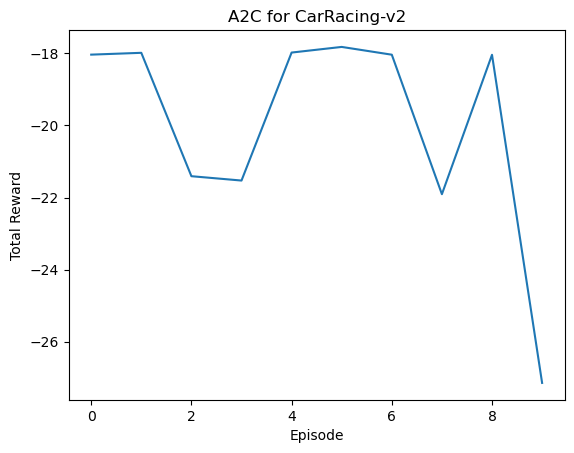

In [8]:
import matplotlib.pyplot as plt

# plot me
plt.plot(total_rewards)
plt.title('A2C for CarRacing-v2')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()